SEMANTIC SEGMENTATION OF AERIAL HIGH RESOLUTION IMAGES

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -uq "/content/gdrive/My Drive/archive.zip" -d "/archive"

In [ ]:
print(os.listdir("/archive/archive"))

['dataset', 'RGB_color_image_masks', 'class_dict_seg.csv']


In [ ]:
num_classes=23
H=800
W=800

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.compat.v1.data.Dataset.from_tensor_slices((x,y)) # Dataset object from Tensorflow
    dataset = dataset.shuffle(buffer_size=100) 
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask


In [ ]:
root_dir = '/archive/archive/dataset/semantic_drone_dataset'
img_path = root_dir + '/original_images/'
mask_path = root_dir + '/label_images_semantic/'

names = list(map(lambda x: x.replace('.jpg', ''), os.listdir(img_path)))

In [ ]:
X_trainval, X_test = train_test_split(names, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

y_train = X_train
y_test = X_test
y_val = X_val

img_train = [os.path.join(img_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(mask_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(img_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(mask_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(img_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(mask_path, f"{name}.png") for name in y_test]

Train Size : 288 images
Val Size   :  72 images
Test Size  :  40 images


In [ ]:
batch_size=3

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

In [ ]:
train_dataset.take(0)

<TakeDataset shapes: ((None, 800, 800, 3), (None, 800, 800, 23)), types: (tf.float32, tf.int32)>

In [ ]:
num_classes=23
H=800
W=800


def test_dataset(x, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (H, W, 3))    # In the Images, number of channels = 3.  
    return image

In [ ]:
pip install segmentation_models

     |████████████████████████████████| 50 kB 7.4 MB/s 


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import os
from glob import glob
from pathlib import Path
import shutil
from random import sample, choice
import segmentation_models as sm

Segmentation Models: using `keras` framework.


ALGORITHM-1 VGG-16 (Encoder) & FCN-8 (Decoder)

In [ ]:
# Downloading the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

# Assigning to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name): # Defining a block in the VGG network.

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

In [ ]:
def VGG_16(image_input): # This function defines the VGG encoder.

  # Creating 5 blocks with increasing filters at each stage.
  # "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # Creating the VGG model
  vgg  = tf.keras.Model(image_input , p5)

  # Loading the pretrained weights downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # Number of filters for the output convolutional layers
  n = 4096

  # Since input images are 800x800 pixels, they will be downsampled to 25x25 after the pooling layers executed above.
  # More features can be extracted by adding two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  return (p1, p2, p3, p4, c7)

In [ ]:
def fcn8_decoder(convs, n_classes): # Defining the FCN-8 decoder.

  # Unpacking the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # Upsampling the output of the encoder then cropping extra pixels that were introduced.
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # Loading the pool-4 prediction and doing a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # Adding the results of the upsampling and pool-4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # UpsamplING the resulting tensor of the operation just performed.
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # Loading the pool-3 prediction and doing a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # Adding the results of the upsampling and pool-3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # Upsampling up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # Appending a softmax layer to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [ ]:
def segmentation_model(): # Defining the final segmentation model by merging together the encoder and decoder.
  
  inputs = tf.keras.layers.Input(shape=(800,800,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 23)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  
  return model

In [ ]:
import tensorflow as tf
model = segmentation_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 800, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 800, 800, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 400, 400, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
# Compiling the model
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
iou = sm.metrics.IOUScore(threshold=0.5)
dice = sm.metrics.FScore()
model.compile(optimizer=sgd, loss='categorical_crossentropy' ,metrics=['accuracy',iou,dice])

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/gdrive/My Drive/Drone-VGG-16-1.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
model.load_weights("/content/gdrive/My Drive/Drone-VGG-16-1.h5")

In [ ]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=10,
          callbacks=[mc] 
         )

Epoch 1/10
96/96 [==============================] - 400s 4s/step - loss: 1.3918 - accuracy: 0.5961 - iou_score: 0.0713 - f1-score: 0.1012 - val_loss: 1.6034 - val_accuracy: 0.5389 - val_iou_score: 0.0492 - val_f1-score: 0.0727

Epoch 00001: val_accuracy improved from -inf to 0.53892, saving model to /content/gdrive/My Drive/Drone-VGG-16-1.h5
Epoch 2/10
96/96 [==============================] - 404s 4s/step - loss: 1.3328 - accuracy: 0.6218 - iou_score: 0.0786 - f1-score: 0.1068 - val_loss: 1.1787 - val_accuracy: 0.6532 - val_iou_score: 0.1022 - val_f1-score: 0.1306

Epoch 00002: val_accuracy improved from 0.53892 to 0.65316, saving model to /content/gdrive/My Drive/Drone-VGG-16-1.h5
Epoch 3/10
96/96 [==============================] - 386s 4s/step - loss: 1.1206 - accuracy: 0.6702 - iou_score: 0.1045 - f1-score: 0.1336 - val_loss: 3.0756 - val_accuracy: 0.3622 - val_iou_score: 0.0517 - val_f1-score: 0.0887

Epoch 00003: val_accuracy did not improve from 0.65316
Epoch 4/10
96/96 [========

In [ ]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

14/14 [==============================] - 33s 2s/step - loss: 0.9814 - accuracy: 0.7197 - iou_score: 0.1273 - f1-score: 0.1514


[0.9814082384109497,
 0.719730794429779,
 0.12725071609020233,
 0.15141643583774567]

In [ ]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

In [ ]:
pred.shape

(40, 800, 800, 23)

In [ ]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (800, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
color_dict = pd.read_csv('/archive/archive/class_dict_seg.csv')
cm = confusion_matrix(label, predictions, labels=range(23))
df_cm = pd.DataFrame(cm,  columns=list(color_dict['name'])[:23])
df_cm

,unlabeled,paved-area,dirt,grass,gravel,water,rocks,pool,vegetation,roof,wall,window,door,fence,fence-pole,person,dog,car,bicycle,tree,bald-tree,ar-marker,obstacle
0,0,19955,185,10887,4191,4,0,1,7197,7816,186,0,0,1,0,7,0,0,0,0,0,0,1079
1,0,8897398,8683,124884,208040,80,0,195,52626,345298,3717,0,0,0,0,16,0,0,0,2,1,0,38573
2,0,96767,15063,148680,142045,63,0,2,238363,9811,472,0,0,2,0,2,0,0,0,0,0,0,9816
3,0,37855,6124,4416224,27759,129,0,0,302083,2729,294,0,0,0,0,0,0,0,0,0,2,0,4249
4,0,397095,1251,53764,1182380,5,0,0,81506,19033,462,0,0,0,0,25,0,0,0,0,0,0,9360
5,0,24270,2159,214983,27199,27,0,3,53578,275,38,0,0,0,0,1,0,0,0,0,0,0,1808
6,0,29093,435,3116,76997,0,0,0,33385,297,103,0,0,0,0,1,0,0,0,0,0,0,1537
7,0,879,52,1098,1677,0,0,0,3874,381,4,0,0,0,0,0,0,0,0,0,0,0,143
8,0,54854,11283,205646,154085,97,0,0,1492593,5475,547,0,0,2,0,5,0,0,0,3,0,0,15826
9,0,505009,954,2622,26246,34,0,0,5207,2288551,2182,0,0,0,0,2,0,0,0,0,0,0,11488


In [ ]:
def iou(cm, i):
    return cm[i,i]/(sum(cm[i])+sum(cm[:,i])-cm[i,i])

print('MIoU: {0}%'.format(round(100*np.mean(np.nan_to_num(np.array([iou(cm, i) for i in range(23)]))), 4)))

MIoU: 13.6093%


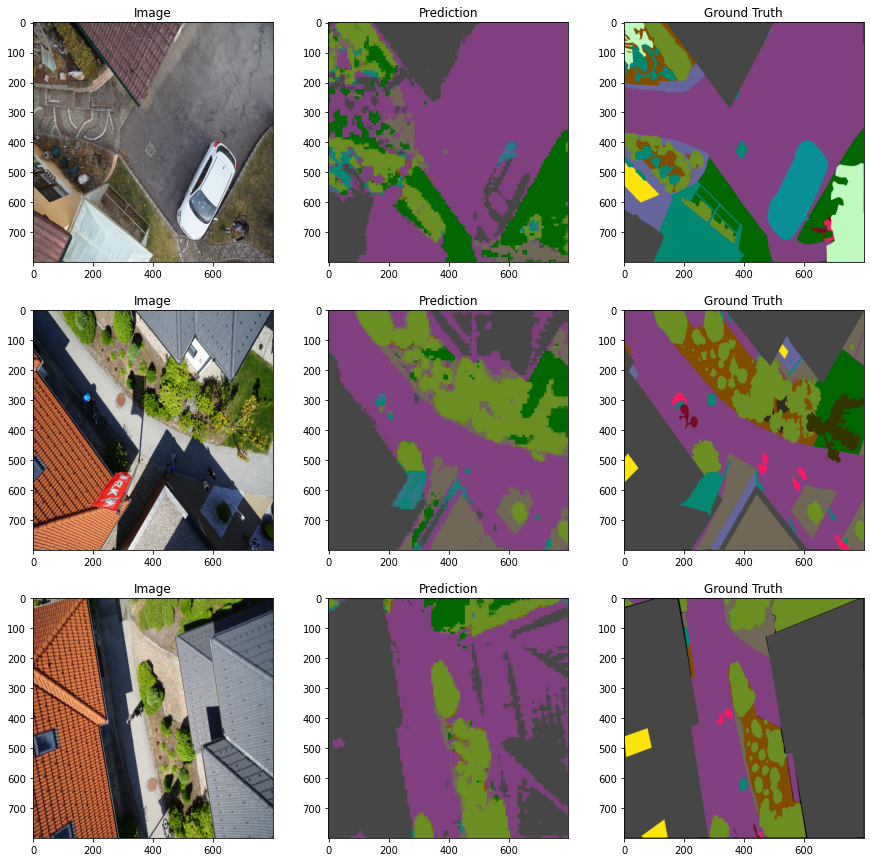

In [ ]:
cmap = np.array(list(color_dict[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 800)
label = label.reshape(-1, 800, 800)


i = 18
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j in range(3):
    x = cv2.imread(img_test[i+j], cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (800, 800))  
    ax[j, 0].imshow(x)
    ax[j, 1].imshow(cmap[predictions[i+j]])
    ax[j, 2].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground Truth')

plt.show()

ALGORITHM-2 UNet

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def unet_model(n_classes=23, IMG_HEIGHT=800, IMG_WIDTH=800, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model

In [ ]:
model = unet_model()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_852 (Conv2D)            (None, 800, 800, 16  448         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 800, 800, 16  0           ['conv2d_852[0][0]']             
                                )                                                           

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/gdrive/My Drive/Drone-UNet3-1.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
iou = sm.metrics.IOUScore(threshold=0.5)
dice = sm.metrics.FScore()
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy',iou,dice])

In [ ]:
model.load_weights("/content/gdrive/My Drive/Drone-UNet3-1.h5")

In [ ]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=10,
          callbacks=[mc] 
         )

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.2647 - accuracy: 0.6316 - iou_score: 0.0881 - f1-score: 0.1213
Epoch 00001: val_accuracy improved from 0.64148 to 0.64857, saving model to /content/gdrive/My Drive/Drone-UNet3-1.h5
96/96 [==============================] - 254s 3s/step - loss: 1.2647 - accuracy: 0.6316 - iou_score: 0.0881 - f1-score: 0.1213 - val_loss: 1.1930 - val_accuracy: 0.6486 - val_iou_score: 0.0846 - val_f1-score: 0.1229
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.6312 - iou_score: 0.0842 - f1-score: 0.1191
Epoch 00002: val_accuracy did not improve from 0.64857
96/96 [==============================] - 247s 3s/step - loss: 1.2568 - accuracy: 0.6312 - iou_score: 0.0842 - f1-score: 0.1191 - val_loss: 1.2139 - val_accuracy: 0.6425 - val_iou_score: 0.0946 - val_f1-score: 0.1257
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 1.2230 - accuracy: 0.6418 - iou_score: 0.0927 - f1-score: 0.1

In [ ]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

14/14 [==============================] - 30s 2s/step - loss: 1.0615 - accuracy: 0.6816 - iou_score: 0.0940 - f1-score: 0.1353


[1.0615214109420776,
 0.6816073656082153,
 0.09395881742238998,
 0.1353156417608261]

In [ ]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

In [ ]:
pred.shape

(40, 800, 800, 23)

In [ ]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (800, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
color_dict = pd.read_csv('/archive/archive/class_dict_seg.csv')
cm = confusion_matrix(label, predictions, labels=range(23))
df_cm = pd.DataFrame(cm,  columns=list(color_dict['name'])[:23])
df_cm

,unlabeled,paved-area,dirt,grass,gravel,water,rocks,pool,vegetation,roof,wall,window,door,fence,fence-pole,person,dog,car,bicycle,tree,bald-tree,ar-marker,obstacle
0,0,20086,1418,12319,2655,21,0,44,3445,1681,0,0,0,0,0,7,0,0,0,31,0,0,475
1,0,9681325,69718,442298,260152,81,0,6561,19274,120342,90,0,0,0,1,641,0,112,0,291,1,51,30958
2,0,67561,286743,277982,18224,86,0,11,100856,2754,18,0,0,0,0,130,0,7,0,284,2,1,753
3,0,29851,44878,3877661,3667,181,0,13,56270,586,20,0,0,0,0,42,0,8,0,1592,7,1,546
4,0,590109,54872,123491,1102726,42,0,7739,82791,41039,13,0,0,0,0,435,0,99,0,794,1,126,60102
5,0,6040,3358,228502,14385,1090,0,18,52244,423,3,0,0,0,0,44,0,3,0,935,0,1,325
6,0,57553,16709,28244,43334,48,0,85,45838,1745,1,0,0,0,0,12,0,2,0,114,1,4,1745
7,0,1029,716,2287,1130,2,0,1739,2483,266,0,0,0,0,0,16,0,0,0,17,0,0,1487
8,0,51270,223248,556527,40608,348,0,86,1009379,23671,24,0,0,0,0,587,0,632,0,6277,0,6,1718
9,0,824324,4774,2661,100673,333,0,6828,1822,1278008,56,0,0,0,0,2810,0,822,0,483,25,448,35321


In [ ]:
def iou(cm, i):
    return cm[i,i]/(sum(cm[i])+sum(cm[:,i])-cm[i,i])

print('MIoU: {0}%'.format(round(100*np.mean(np.nan_to_num(np.array([iou(cm, i) for i in range(23)]))), 4)))

MIoU: 13.1369%


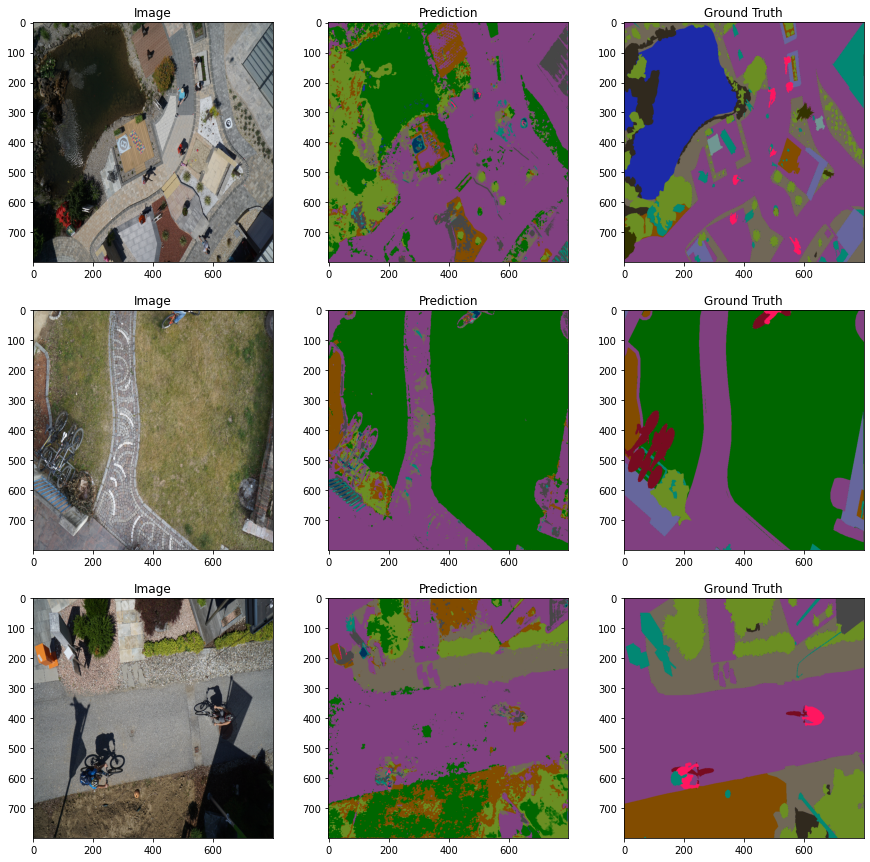

In [ ]:
cmap = np.array(list(color_dict[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 800)
label = label.reshape(-1, 800, 800)


i = 18
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j in range(3):
    x = cv2.imread(img_test[i+j], cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (800, 800))  
    ax[j, 0].imshow(x)
    ax[j, 1].imshow(cmap[predictions[i+j]])
    ax[j, 2].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground Truth')

plt.show()

ALGORITHM-3 SegNet

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
def segnet():

    # Encoding layer
    img_input = Input(shape= (800, 800, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    '''x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)'''

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    '''x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)'''
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(23, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=img_input, outputs=x)

    return model


In [ ]:
model = segnet()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 800, 800, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 800, 800, 64)      1792      
                                                                 
 bn1 (BatchNormalization)    (None, 800, 800, 64)      256       
                                                                 
 activation_929 (Activation)  (None, 800, 800, 64)     0         
                                                                 
 conv2 (Conv2D)              (None, 800, 800, 64)      36928     
                                                                 
 bn2 (BatchNormalization)    (None, 800, 800, 64)      256       
                                                                 
 activation_930 (Activation)  (None, 800, 800, 64)     0   

In [ ]:
model.load_weights("/content/gdrive/My Drive/Drone-SegNet2-1.h5")

In [ ]:
iou = sm.metrics.IOUScore(threshold=0.5)
dice = sm.metrics.FScore()
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy',iou,dice])

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(mode='max', filepath='/content/gdrive/My Drive/Drone-SegNet3-1.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)

In [ ]:
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=5,
          callbacks=[mc] 
         )

Epoch 1/5
96/96 [==============================] - ETA: 0s - loss: 1.9051 - accuracy: 0.5576 - iou_score: 0.0371 - f1-score: 0.0742
Epoch 00001: val_accuracy did not improve from 0.51212
96/96 [==============================] - 524s 5s/step - loss: 1.9051 - accuracy: 0.5576 - iou_score: 0.0371 - f1-score: 0.0742 - val_loss: 2.8080 - val_accuracy: 0.4697 - val_iou_score: 0.0719 - val_f1-score: 0.0854
Epoch 2/5
96/96 [==============================] - ETA: 0s - loss: 1.7879 - accuracy: 0.5848 - iou_score: 0.0473 - f1-score: 0.0822
Epoch 00002: val_accuracy did not improve from 0.51212
96/96 [==============================] - 522s 5s/step - loss: 1.7879 - accuracy: 0.5848 - iou_score: 0.0473 - f1-score: 0.0822 - val_loss: 2.6433 - val_accuracy: 0.4996 - val_iou_score: 0.0689 - val_f1-score: 0.0937
Epoch 3/5
96/96 [==============================] - ETA: 0s - loss: 1.7052 - accuracy: 0.6005 - iou_score: 0.0633 - f1-score: 0.0895
Epoch 00003: val_accuracy did not improve from 0.51212
96/96 [

In [ ]:
test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)

14/14 [==============================] - 38s 3s/step - loss: 2.5067 - accuracy: 0.5828 - iou_score: 0.0786 - f1-score: 0.0985


[2.506734848022461,
 0.5828285813331604,
 0.07860630005598068,
 0.0985124483704567]

In [ ]:
pred = model.predict(test_dataset(img_test, batch = 1), steps=40)

In [ ]:
pred.shape

(40, 800, 800, 23)

In [ ]:
predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(mask_path+img_test[i][-7:-4]+'.png')[:, :, 0], (800, 800)) for i in range(predictions.shape[0])])
label = label.flatten()
predictions = predictions.flatten()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
color_dict = pd.read_csv('/archive/archive/class_dict_seg.csv')
cm = confusion_matrix(label, predictions, labels=range(23))
df_cm = pd.DataFrame(cm,  columns=list(color_dict['name'])[:23])
df_cm

,unlabeled,paved-area,dirt,grass,gravel,water,rocks,pool,vegetation,roof,wall,window,door,fence,fence-pole,person,dog,car,bicycle,tree,bald-tree,ar-marker,obstacle
0,4280,13425,4,11863,7074,0,0,13,5518,1,0,0,0,0,0,0,0,0,0,0,0,4,0
1,8844,8285913,143,136186,1678068,0,0,3813,518496,8,0,0,0,0,0,0,0,0,0,0,0,367,58
2,1377,28317,59,117170,37376,0,0,2,571091,0,0,0,0,0,0,0,0,0,0,0,0,18,2
3,411,29462,6,3351240,22449,0,0,4,611749,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,1281,138640,77,60141,1270661,0,0,2688,589339,0,0,0,0,0,0,0,0,0,0,0,0,1470,82
5,110,575,0,160853,2535,0,0,28,143262,0,0,0,0,0,0,0,0,0,0,0,0,5,3
6,173,8988,27,5186,46851,0,0,28,134177,0,0,0,0,0,0,0,0,0,0,0,0,2,3
7,3,245,0,616,3704,0,0,670,5923,0,0,0,0,0,0,0,0,0,0,0,0,11,0
8,747,8307,44,90412,42853,0,0,11,1772002,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9,1217,1024846,75,10950,708687,0,0,5186,267786,235376,0,0,0,0,0,0,0,0,0,0,0,0,5265


In [ ]:
def iou(cm, i):
    return cm[i,i]/(sum(cm[i])+sum(cm[:,i])-cm[i,i])

print('MIoU: {0}%'.format(round(100*np.mean(np.nan_to_num(np.array([iou(cm, i) for i in range(23)]))), 4)))

MIoU: 8.8881%


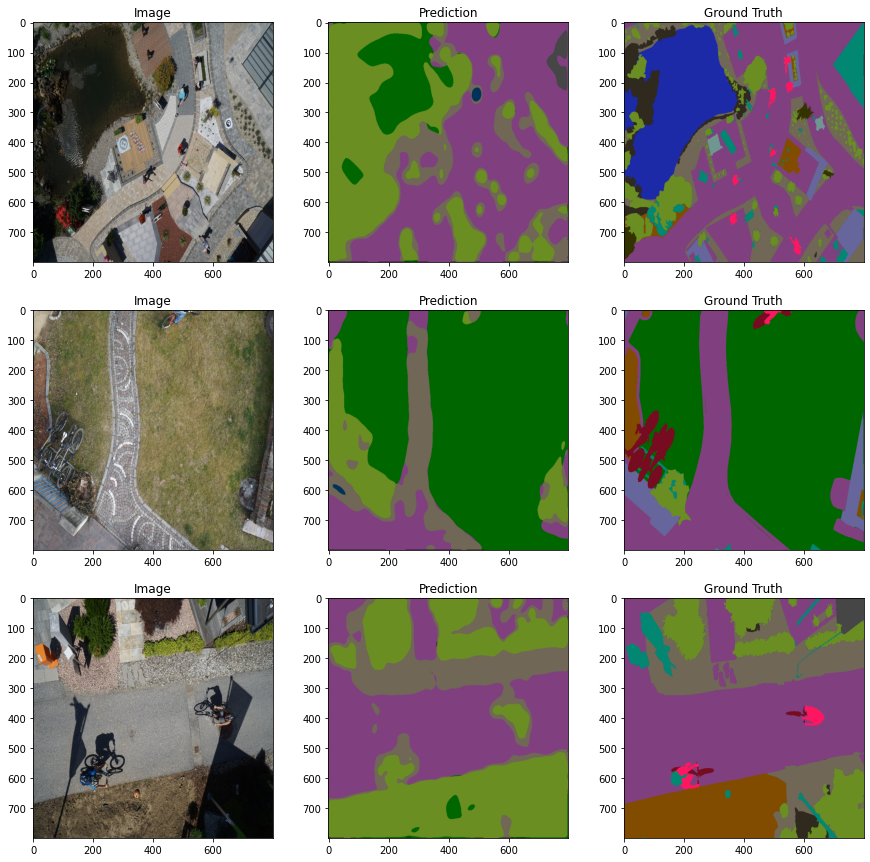

In [ ]:
cmap = np.array(list(color_dict[[' r', ' g', ' b']].transpose().to_dict('list').values()))
predictions = predictions.reshape(-1, 800, 800)
label = label.reshape(-1, 800, 800)


i = 18
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j in range(3):
    x = cv2.imread(img_test[i+j], cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (800, 800))  
    ax[j, 0].imshow(x)
    ax[j, 1].imshow(cmap[predictions[i+j]])
    ax[j, 2].imshow(cmap[label[i+j]])
    ax[j, 0].set_title('Image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground Truth')

plt.show()